In [ ]:


import sys
sys.path.insert(1, "../")
import numpy as np
import pandas as pd
import tensorflow as tf
np.random.seed(0)
import aif360
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric, Metric
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import StructuredDataset
from aif360.datasets import StandardDataset
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from aif360.algorithms.preprocessing import DisparateImpactRemover
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.inprocessing import PrejudiceRemover
from sklearn.model_selection import train_test_split
from IPython.display import Markdown, display
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import f_oneway
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-white')
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly import tools

In [ ]:
df=pd.read_csv("C:/Users/danie/OneDrive/Desktop/Diabete/diabetes.csv")
df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


L'outcome indica se il paziente viene identificato come diabetico osservando le varie analisi o meno

# PRE-PROCESSING

Controlliamo prima di tutto la presenza di valori nulli

In [ ]:
def check_null_value(array,name):
    p=array.isnull().sum()
    print("The number of missing value in "+name+" is "+ str(p))
    return p

In [ ]:
preg_null=check_null_value(df["Pregnancies"],"Pregnancies")
gluc_null=check_null_value(df["Glucose"],"Glucose")
pres_null=check_null_value(df["BloodPressure"],"BloodPressure")
skin_null=check_null_value(df["SkinThickness"],"SkinThickness")
insu_null=check_null_value(df["Insulin"],"Insulin")
bmi_null=check_null_value(df["BMI"],"BMI")
diab_null=check_null_value(df["DiabetesPedigreeFunction"],"DiabetesPedigreeFunction")
age_null=check_null_value(df["Age"],"Age")
out_null=check_null_value(df["Outcome"],"Outcome")

The number of missing value in Pregnancies is 0
The number of missing value in Glucose is 0
The number of missing value in BloodPressure is 0
The number of missing value in SkinThickness is 0
The number of missing value in Insulin is 0
The number of missing value in BMI is 0
The number of missing value in DiabetesPedigreeFunction is 0
The number of missing value in Age is 0
The number of missing value in Outcome is 0


Dal risultato emerge che non ci sono valori tutti, tuttavia proviamo a fare delle computazioni sulle distribuzioni, per vedere la presenza di outlier.

# INSULINE

In [ ]:
df1=df[df["Insulin"]==0]
print(df1["Insulin"].value_counts())

0    374
Name: Insulin, dtype: int64


Ho trovato 374 valori di insulina a 0. Questi vengono intepretati come valori nulli, quindi li rimpiazzo con la mediana.

In [ ]:
df["Insulin"]=df["Insulin"].replace(0,df["Insulin"].median())

Text(0.5, 0, 'Insulin mu/ml')

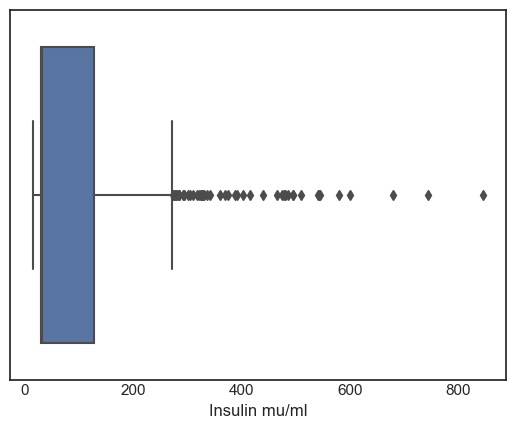

In [ ]:
sns.boxplot(x=df["Insulin"])
plt.xlabel('Insulin mu/ml')

Vediamo di identificare gli outlier. Se un numero è inferiore a q1-1.5 * IQR o maggiore di Q3+1.5 * IQR allora è un valore anomalo.


Cominciamo a vedere di identificare gli outlier per l'insulina

In [ ]:
def detect_outliers(column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    IQR = q3 - q1
    return df[column][(df[column] < (q1-1.5*IQR))|(df[column] > (q3 + 1.5*IQR))].tolist()


In [ ]:
outlier_insulin=detect_outliers('Insulin')

Una volta individuati li sostituiamo con il valore della mediana

In [ ]:
def replace_outlier_with_median(column,outliers):
    df[column] = np.where(df[column].isin(outliers),df[column].median(),df[column])
    return df[column]

In [ ]:
df["Insulin"]=replace_outlier_with_median('Insulin',outlier_insulin)

Text(0.5, 0, 'Insulin mu/ml')

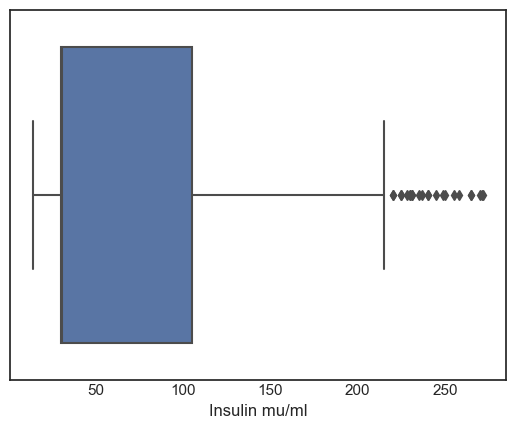

In [ ]:
sns.boxplot(x=df["Insulin"])
plt.xlabel('Insulin mu/ml')

plottiamo la distribuzione dell'insulina

(array([440.,  54.,  57.,  55.,  48.,  37.,  36.,  20.,  12.,   9.]),
 array([ 14. ,  39.8,  65.6,  91.4, 117.2, 143. , 168.8, 194.6, 220.4,
        246.2, 272. ]),
 <BarContainer object of 10 artists>)

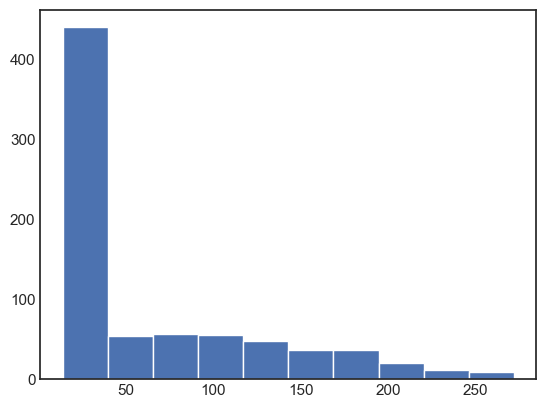

In [ ]:
plt.hist(df["Insulin"])

# GLUCOSE

Text(0.5, 0, 'Glucose 2 hour')

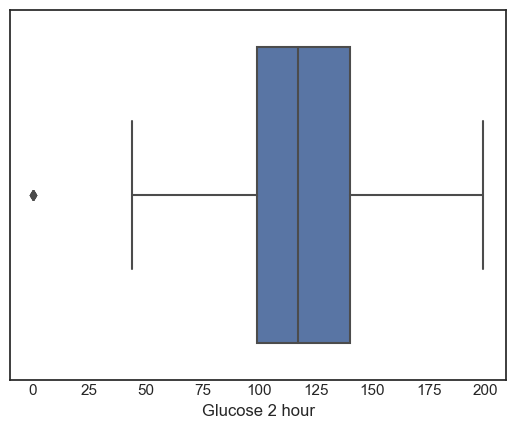

In [ ]:
sns.boxplot(x=df["Glucose"])
plt.xlabel('Glucose 2 hour')

Dal grafico per quanto riguarda il glucosio non emergono particolari problemi

(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <BarContainer object of 10 artists>)

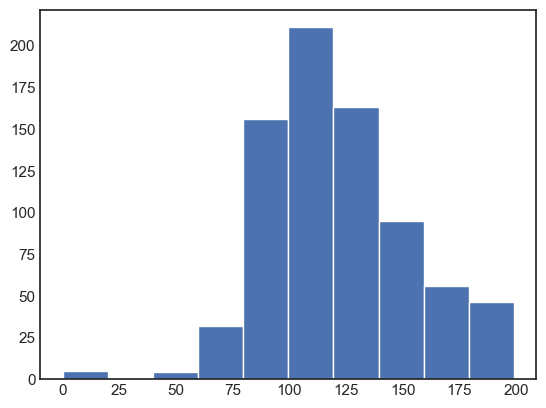

In [ ]:
plt.hist(df["Glucose"])

In [ ]:
df1=df[df["Glucose"]==0]
print(df1["Glucose"].value_counts())

0    5
Name: Glucose, dtype: int64


Essendoci solo 5 valori nulli, possiamo decidere se eliminarli oppure se rimpiazzarli con la mediana. In questo caso ho deciso di eliminarli

In [ ]:
lista=df1["Glucose"].index
lista

Int64Index([75, 182, 342, 349, 502], dtype='int64')

In [ ]:
df=df.drop(lista)

# BLOOD PRESSURE

Text(0.5, 0, 'Diastolic blood pressure (mm Hg) ')

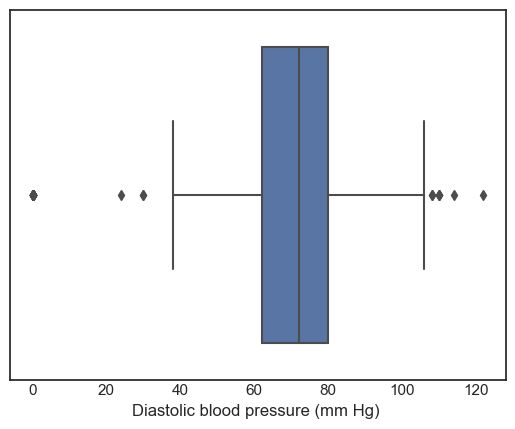

In [ ]:
sns.boxplot(x=df["BloodPressure"])
plt.xlabel('Diastolic blood pressure (mm Hg) ')

Anche da questo grafico emergono la presenza di outlier. Anche per questi sostituiamo il valore della mediana

In [ ]:
outlier_pressure=detect_outliers('BloodPressure')
df["BloodPressure"]=replace_outlier_with_median('BloodPressure',outlier_pressure)

Text(0.5, 0, 'Diastolic blood pressure (mm Hg) ')

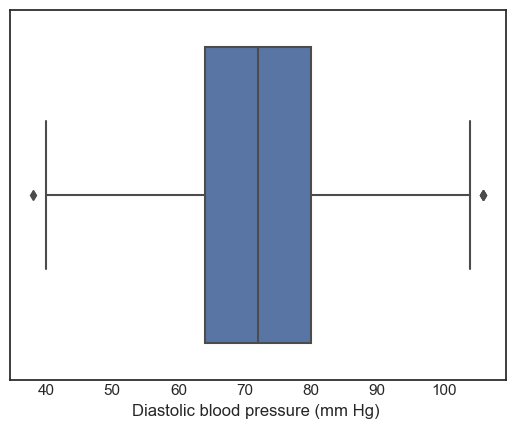

In [ ]:
sns.boxplot(x=df["BloodPressure"])
plt.xlabel('Diastolic blood pressure (mm Hg) ')

(array([  6.,  19.,  57., 122., 130., 232.,  98.,  76.,  14.,   9.]),
 array([ 38. ,  44.8,  51.6,  58.4,  65.2,  72. ,  78.8,  85.6,  92.4,
         99.2, 106. ]),
 <BarContainer object of 10 artists>)

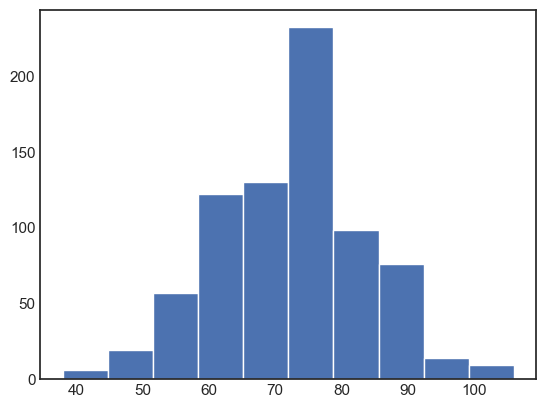

In [ ]:
plt.hist(df["BloodPressure"])

# PREGNANCIES

Text(0.5, 0, ' Number of times pregnant ')

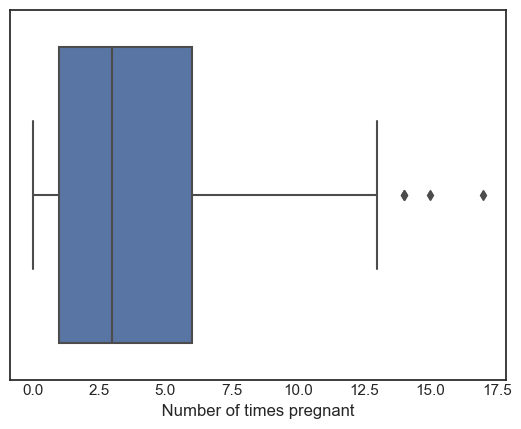

In [ ]:
sns.boxplot(x=df["Pregnancies"])
plt.xlabel(' Number of times pregnant ')

Come notiamo qui effettivamente abbiamo degli outlier ben evidenti, e li rimuoviamo

In [ ]:
outlier_preg=detect_outliers('Pregnancies')
df["Pregnancies"]=replace_outlier_with_median('Pregnancies',outlier_preg)

Text(0.5, 0, ' Number of times pregnant ')

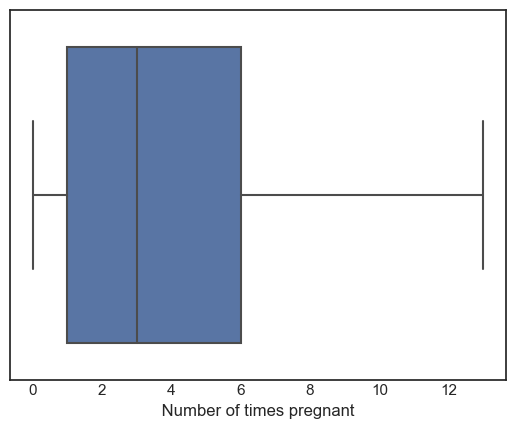

In [ ]:
sns.boxplot(x=df["Pregnancies"])
plt.xlabel(' Number of times pregnant ')

(array([243., 103.,  79., 124.,  49.,  45.,  66.,  24.,  11.,  19.]),
 array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]),
 <BarContainer object of 10 artists>)

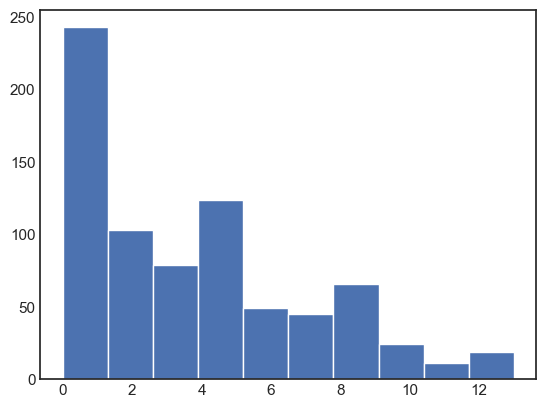

In [ ]:
plt.hist(df["Pregnancies"])

# SKINTHICKNESS

In [ ]:
df1=df[df["SkinThickness"]==0]
print(df1["SkinThickness"].value_counts())

0    227
Name: SkinThickness, dtype: int64


La presenza di 227 valori nulli è alquanto ingente, per questo ho deciso in questo caso di sostituirli con la mediana e di non dropparli.

In [ ]:
df["SkinThickness"]=df["SkinThickness"].replace(0,df["SkinThickness"].median())

Text(0.5, 0, 'Triceps skin fold thickness (mm) ')

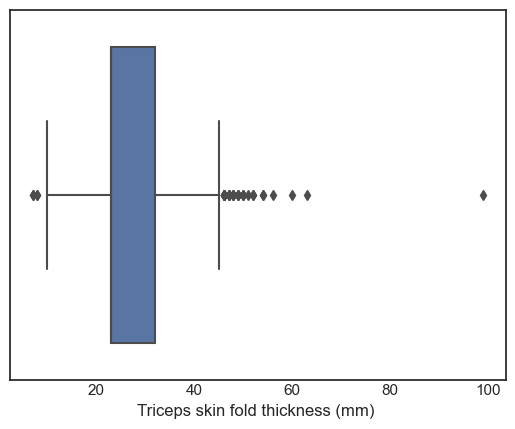

In [ ]:
sns.boxplot(x=df["SkinThickness"])
plt.xlabel('Triceps skin fold thickness (mm) ')

In [ ]:
outlier_skin=detect_outliers('SkinThickness')
df["SkinThickness"]=replace_outlier_with_median('SkinThickness',outlier_skin)

Text(0.5, 0, 'Triceps skin fold thickness (mm) ')

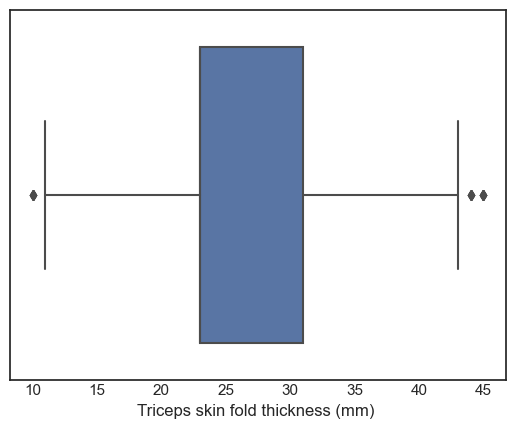

In [ ]:
sns.boxplot(x=df["SkinThickness"])
plt.xlabel('Triceps skin fold thickness (mm) ')

(array([ 29.,  26.,  63., 310.,  67.,  64.,  77.,  44.,  55.,  28.]),
 array([10. , 13.5, 17. , 20.5, 24. , 27.5, 31. , 34.5, 38. , 41.5, 45. ]),
 <BarContainer object of 10 artists>)

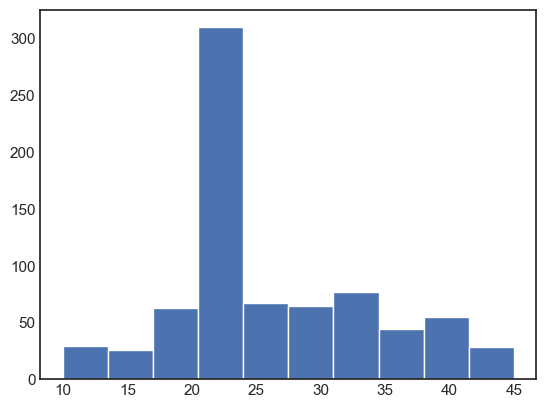

In [ ]:
plt.hist(df["SkinThickness"])

# BMI

Text(0.5, 0, 'Body mass index (weight in kg/(height in m)^2)  ')

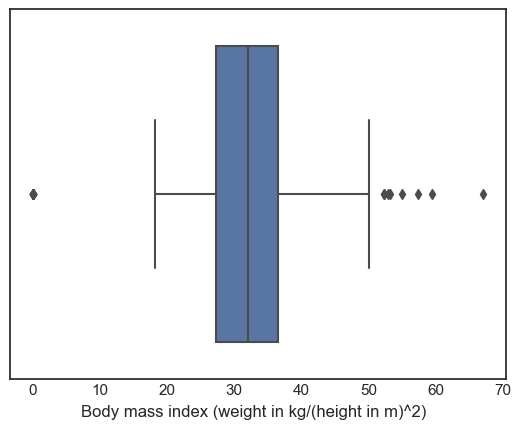

In [ ]:
sns.boxplot(x=df["BMI"])
plt.xlabel('Body mass index (weight in kg/(height in m)^2)  ')

In [ ]:
outlier_bmi=detect_outliers('BMI')
df["BMI"]=replace_outlier_with_median('BMI',outlier_bmi)

Text(0.5, 0, 'Body mass index (weight in kg/(height in m)^2)  ')

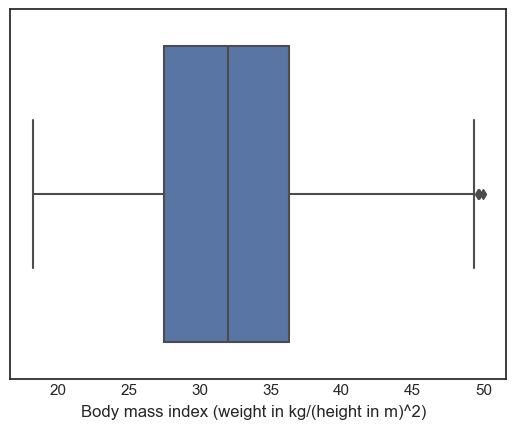

In [ ]:
sns.boxplot(x=df["BMI"])
plt.xlabel('Body mass index (weight in kg/(height in m)^2)  ')

(array([ 26.,  67., 109., 128., 151., 121.,  76.,  49.,  28.,   8.]),
 array([18.2 , 21.38, 24.56, 27.74, 30.92, 34.1 , 37.28, 40.46, 43.64,
        46.82, 50.  ]),
 <BarContainer object of 10 artists>)

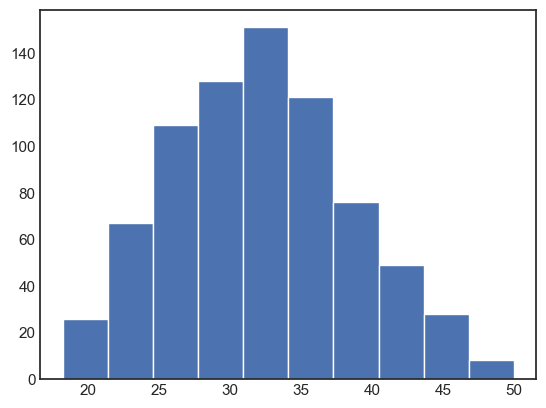

In [ ]:
plt.hist(df["BMI"])

# Diabetes Pedigree Function

Diabetes Pedigree Function: Indica la funzione che valuta la probabilità di avere il diabete in base alla storia familiare

Text(0.5, 0, 'Diabetes pedigree function ')

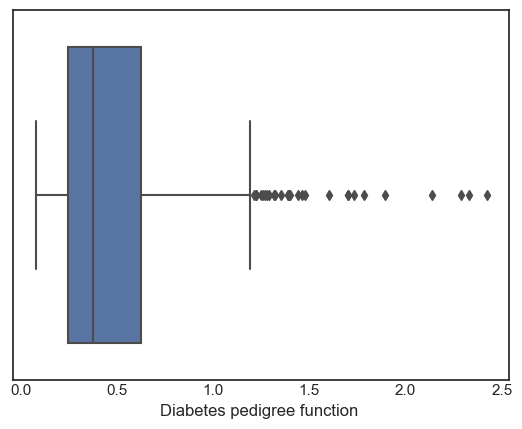

In [ ]:
sns.boxplot(x=df["DiabetesPedigreeFunction"])
plt.xlabel('Diabetes pedigree function ')

In [ ]:
outlier_diab=detect_outliers('DiabetesPedigreeFunction')
df["DiabetesPedigreeFunction"]=replace_outlier_with_median('DiabetesPedigreeFunction',outlier_diab)

Text(0.5, 0, 'Diabetes pedigree function ')

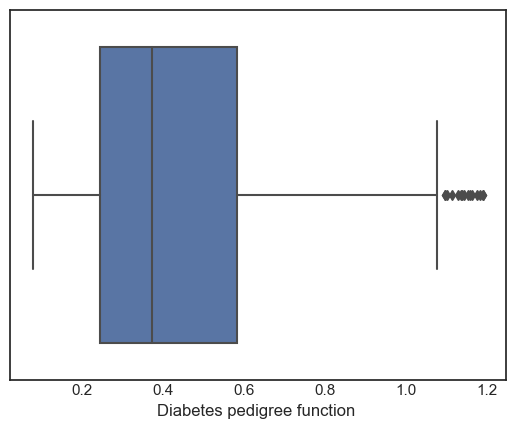

In [ ]:
sns.boxplot(x=df["DiabetesPedigreeFunction"])
plt.xlabel('Diabetes pedigree function ')

Rimpiazzo con il valore della media

In [ ]:
df1=df[df["DiabetesPedigreeFunction"]>1]
lista=df1["DiabetesPedigreeFunction"]
lista1=list(lista)

In [ ]:
df["DiabetesPedigreeFunction"]=df["DiabetesPedigreeFunction"].replace(lista1,df["DiabetesPedigreeFunction"].mean())

Text(0.5, 0, 'Diabetes pedigree function ')

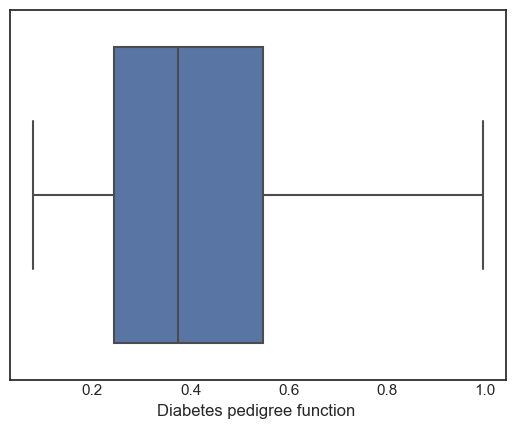

In [ ]:
sns.boxplot(x=df["DiabetesPedigreeFunction"])
plt.xlabel('Diabetes pedigree function ')

(array([ 83., 159., 122., 136.,  64.,  61.,  56.,  34.,  30.,  18.]),
 array([0.078 , 0.1699, 0.2618, 0.3537, 0.4456, 0.5375, 0.6294, 0.7213,
        0.8132, 0.9051, 0.997 ]),
 <BarContainer object of 10 artists>)

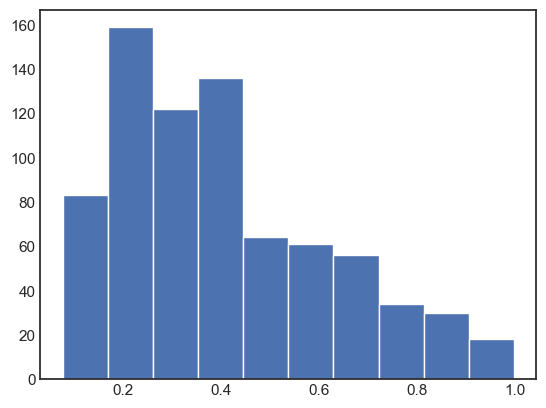

In [ ]:
plt.hist(df["DiabetesPedigreeFunction"])

# AGE

Text(0.5, 0, 'years ')

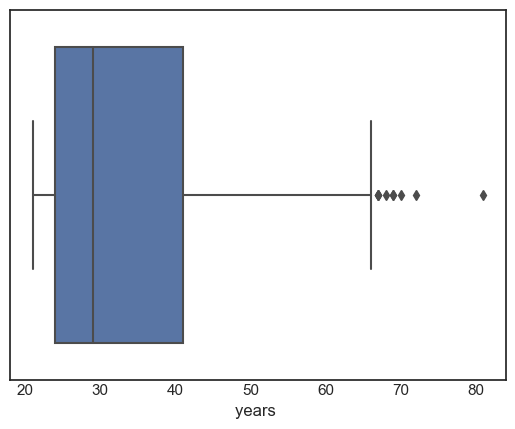

In [ ]:
sns.boxplot(x=df["Age"])
plt.xlabel('years ')

In [ ]:
outlier_age=detect_outliers('Age')
df["Age"]=replace_outlier_with_median('Age',outlier_age)

Text(0.5, 0, 'years ')

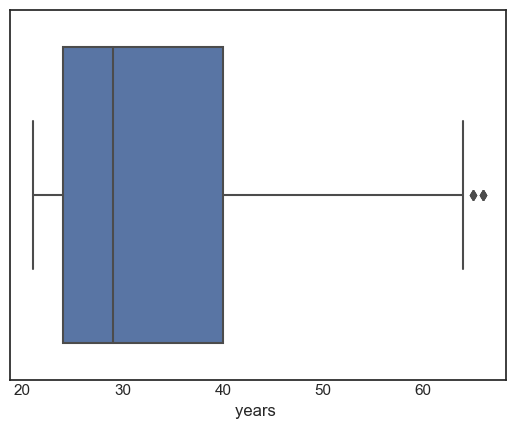

In [ ]:
sns.boxplot(x=df["Age"])
plt.xlabel('years ')

(array([264., 138.,  92.,  60.,  77.,  42.,  34.,  18.,  22.,  16.]),
 array([21. , 25.5, 30. , 34.5, 39. , 43.5, 48. , 52.5, 57. , 61.5, 66. ]),
 <BarContainer object of 10 artists>)

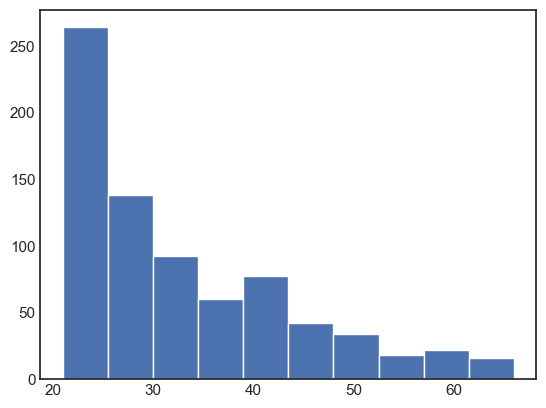

In [ ]:
plt.hist(df["Age"])

Plottiamo l'outcome per vedere quante persone sono identificate come diabetiche nel dataset

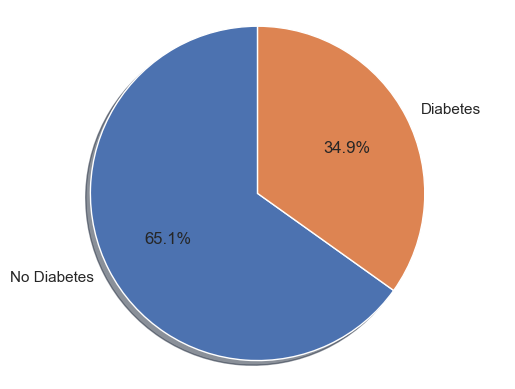

In [ ]:
labels='No Diabetes','Diabetes'
size0, size1 = df["Outcome"].value_counts()
sizes = [size0, size1]
explode = (0, 0)
fig1, ax1= plt.subplots()
ax1.pie(sizes,explode=explode,labels=labels,autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()


Dal risultato della computazione dell'outcome, il 65.1% di donne non è identificata come diabetica, mentre il 34.9% si

# AIF360

Ora bisogna andare ad identificare il mio protected attribute. Possiamo seguire due strade. La prima è creare una seconda colonna che codifichi l'eta come young,adult,old. La seconda invece è lasciare i valori numerici. Il mio scopo sarebbe capire se c'è una discriminazione verso candidati di una determinata categoria di età.
Bisognerebbe valutare se anche il BMI può essere identificato come un attributo protetto o meno. Per ora non lo considero come tale, poi vedo.

Categorizziamo l'età come young e adult. In particolare se l'età è >25 sei considerato come adult

identifico come privileged value Adult, perchè secondo me è piu probabile che tu possa essere classificato come diabetico

Fatto la categorizzazione compute la distribuzione del protected attribute, e identifico come privileged value quella categoria di adulti. Perchè ? Perchè magari uno pensa che da adulti la probabilità di essere diabetico possa aumentare.

In [ ]:
def età(row):
    if(row["Age"]>25):
        return 'Adult'
    else:
        return 'Young'

In [ ]:
df["AgeCategory"]=df.apply(lambda row: età(row), axis=1)

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeCategory
0,6.0,148,72.0,35.0,30.5,33.6,0.627,50.0,1,Adult
1,1.0,85,66.0,29.0,30.5,26.6,0.351,31.0,0,Adult
2,8.0,183,64.0,23.0,30.5,23.3,0.672,32.0,1,Adult
3,1.0,89,66.0,23.0,94.0,28.1,0.167,21.0,0,Young
4,0.0,137,40.0,35.0,168.0,43.1,0.374,33.0,1,Adult


A questo punto rimpiazzo il valore 1 con Adult, e il valore 0 con Young

In [ ]:
def visualize_att_dist(_data, _att, _category=False):
    plt.figure(figsize=[12,5], dpi=100)
    sns.set(style="darkgrid")
    sns.set(font_scale = 1.5)
    if _category: # for categorical attribute
        vis_data = _data[_att].value_counts()
        ax = sns.barplot(x=vis_data.index, y=vis_data.values);
        ax.set_xlabel(_att)
        if len(vis_data) >= 5:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    else:
        ax = sns.distplot(_data[_att], kde=False, color='steelblue');
    ax.set_ylabel("Count")
    plt.tight_layout()

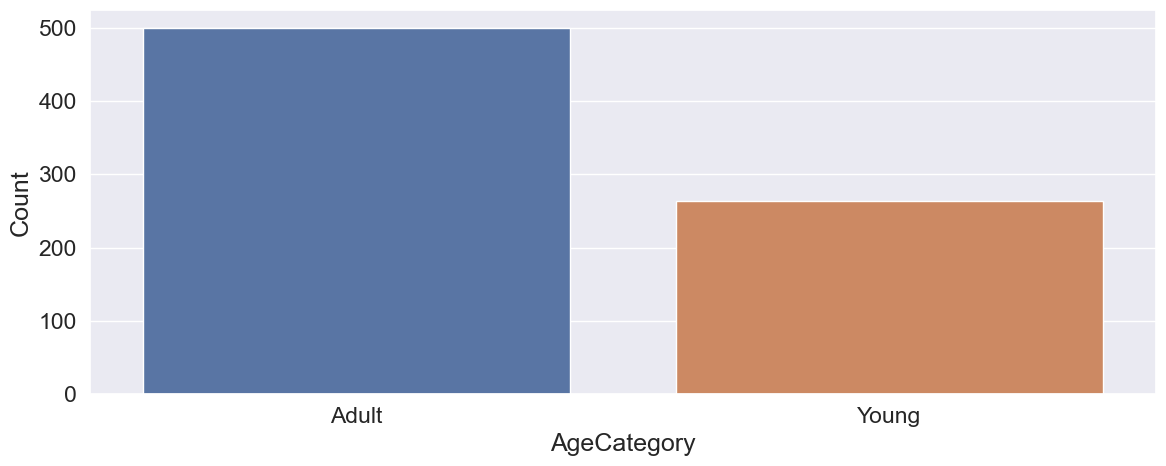

In [ ]:
visualize_att_dist(df, "AgeCategory", _category=True)

In [ ]:
df=df.replace({"Adult":1})

In [ ]:
df=df.replace({"Young":0})

In [ ]:
#privileged_age=np.where(df["AgeCategory"]==0)[0]

In [ ]:
df1=df.copy()

In [ ]:
data_orig_age = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=df1,
    label_names=['Outcome'],
    protected_attribute_names=['AgeCategory'])

In [ ]:
np.random.seed(42)

data_orig_age_train, data_orig_age_test = data_orig_age.split([0.7], shuffle=True)

display(Markdown("#### Train Dataset shape"))
print("Age :",data_orig_age_train.features.shape)
display(Markdown("#### Test Dataset shape"))
print("Age :",data_orig_age_test.features.shape)

#### Train Dataset shape

Age : (534, 9)


#### Test Dataset shape

Age : (229, 9)


In [ ]:
rf_orig_age = RandomForestClassifier().fit(data_orig_age_train.features,
                     data_orig_age_train.labels.ravel(),
                     sample_weight=data_orig_age_train.instance_weights)

In [ ]:
X_test_age = data_orig_age_test.features
y_test_age = data_orig_age_test.labels.ravel()

In [ ]:
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [ ]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred

    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]

    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)

    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}]
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}]

        classified_metric = ClassificationMetric(dataset,
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)

    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)

    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125,
        bottom  =  0.1,
        right   =  0.9,
        top     =  0.9,
        wspace  =  .5,
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])

        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')
        ax.set_xlabel('')

In [ ]:
def get_fair_metrics_and_plot(data, model, plot=True, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360
        plot_fair_metrics(fair)
        display(fair)

    return fair

### Bias metrics for the Sex model

C:\Users\danie\AppData\Local\Temp\ipykernel_3416\2902889714.py:37: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the AgeCategory attribute :

With default thresholds, bias against unprivileged group detected in **4** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.000000,0.000000,1.000000,0.000000
AgeCategory,-0.344302,-0.362193,0.302006,0.149679,0.183977


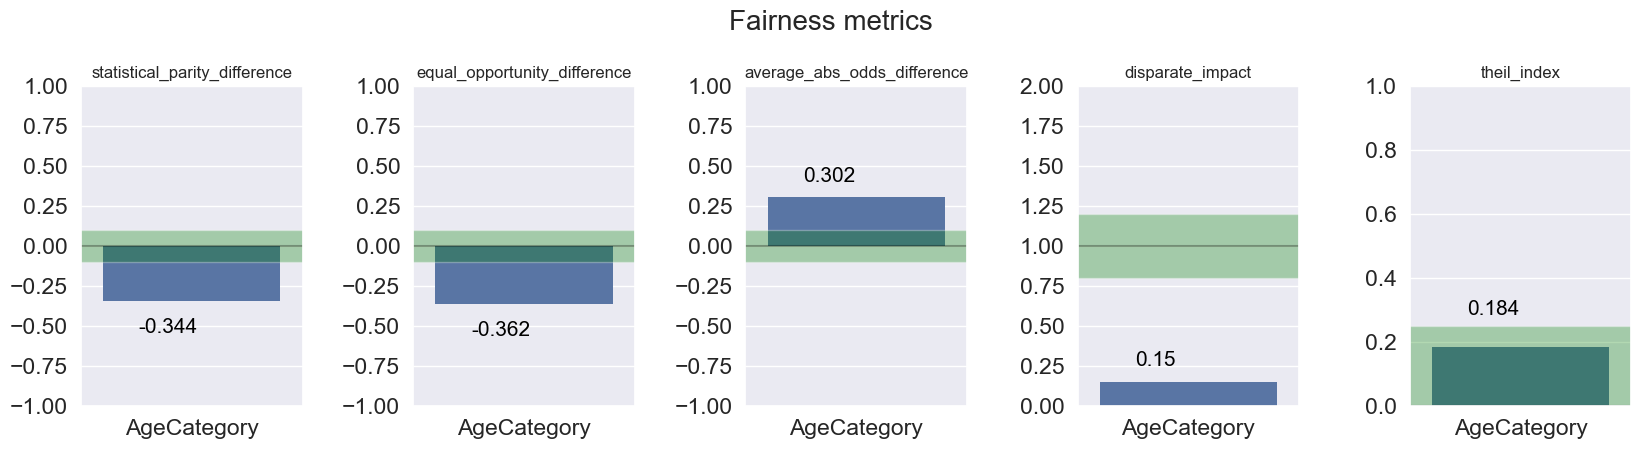

In [ ]:
display(Markdown('### Bias metrics for the Sex model'))
fair = get_fair_metrics_and_plot(data_orig_age_test, rf_orig_age)

Dai risultati delle metriche ottenute, emerge come ci sia un bias verso la popolazione giovane, riscontrata in 4 metriche su 5. Questo ci indica che nella diagnosi del diabete, in questo dataset è presente un bias verso i giovani, i quali non vengono considerati in mangiera eguale degli adulti.

# DENSITY

Nella computazione della density voglio analizzare questi: AgeCategory vs outcome

In [ ]:
cont=pd.crosstab(df["AgeCategory"], df["Outcome"])
print(cont)


Outcome        0    1
AgeCategory          
0            219   45
1            278  221


Text(0, 0.5, 'Count')

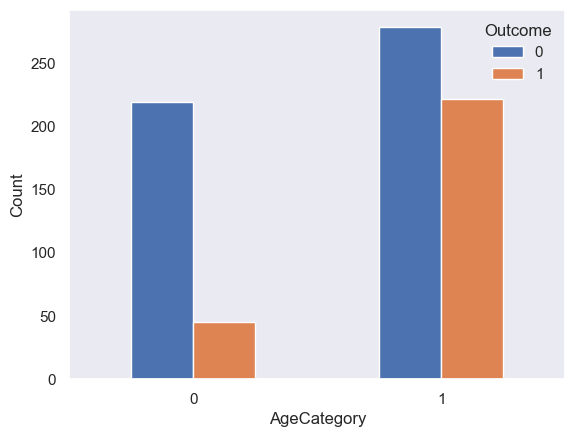

In [ ]:
barplot = cont.plot.bar(rot=0)
plt.ylabel("Count")

In [ ]:
from scipy.stats import chi2_contingency

In [ ]:
ChiSqResult = chi2_contingency(cont)
ChiSqResult

(55.236001347523995,
 1.0689287189575323e-13,
 1,
 array([[171.96330275,  92.03669725],
        [325.03669725, 173.96330275]]))

In [ ]:
print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

The P-Value of the ChiSq Test is: 1.0689287189575323e-13


The two variables are correlated

Da questo risultato emerge come per quanto riguarda le persone Giovani( 200 non è stato diagnosticato il diabete, mentre a circa 50 si). Per gli Adulti piu di 250 sono classificati come "non diabetici", mentre circa 200 sono classificati come "Diabetici".

Vediamo ora come si distribuiscono le categorie di età rispetto ai classici parametri presenti nel dataset

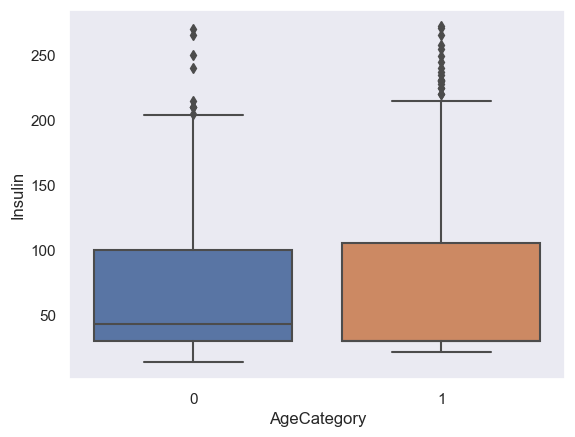

In [ ]:
sns.boxplot(data = df, x = 'AgeCategory', y = 'Insulin')
plt.show()


Per studiare la correlazione tra una variabile categorica e una numerica facciamo uso di un indice particolare chiamato point biserial correlation.

In [ ]:
from scipy import stats

In [ ]:
def correlazione(array1,array2):
    a=stats.pointbiserialr(array1, array2)
    return a

In [ ]:
corAgeInsulin=correlazione(df1["AgeCategory"],df1["Insulin"])
corAgeInsulin

PointbiserialrResult(correlation=-0.005388516712148568, pvalue=0.8818683998569106)

Dal risultato emerge come la correlazione tra persone diabetiche e agecategory sia relativamente bassa

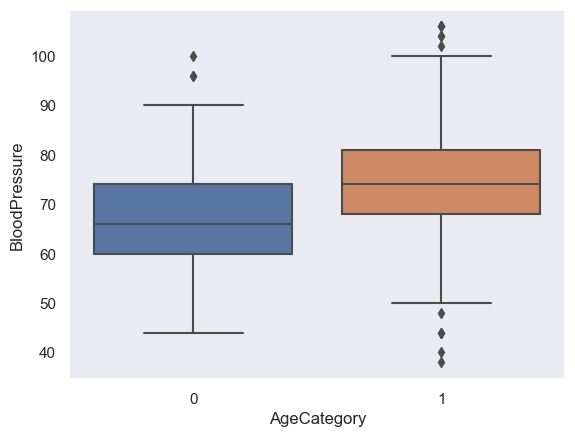

In [ ]:
sns.boxplot(data = df1, x = 'AgeCategory', y = 'BloodPressure')
plt.show()

Dal risultato emerge che tra la PressioneSanguigna e l'età c'è un certo grado di correlazione, in particolare i giovani tendono ad avere un minimo più elevato degli adulti, e un massimo livello minore rispetto agli adulti.

In [ ]:
corAgePressure=correlazione(df1["AgeCategory"],df1["BloodPressure"])
corAgePressure

PointbiserialrResult(correlation=0.30577472263021443, pvalue=5.612190125450961e-18)

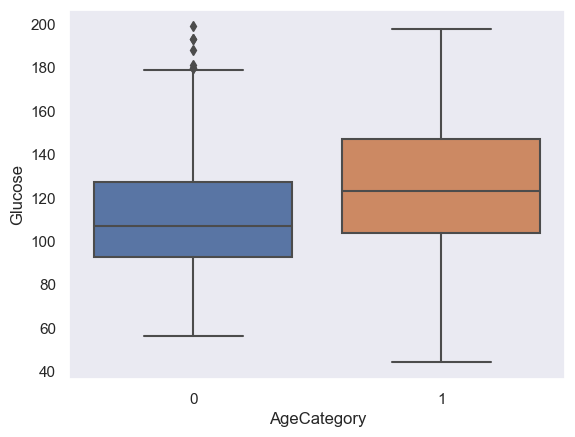

In [ ]:
sns.boxplot(data = df1, x = 'AgeCategory', y = 'Glucose')
plt.show()

In [ ]:
corAgeGlucose=correlazione(df1["Glucose"],df1["AgeCategory"])
corAgeGlucose

PointbiserialrResult(correlation=0.23143330261585485, pvalue=9.779682186549376e-11)

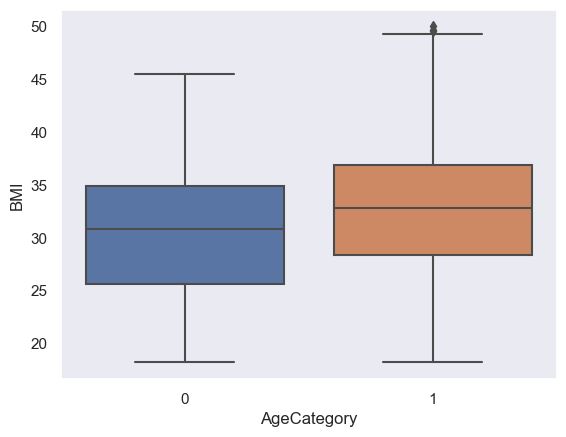

In [ ]:
sns.boxplot(data = df1, x = 'AgeCategory', y = 'BMI')
plt.show()

In [ ]:
corAgeBMI=correlazione(df1["BMI"],df1["AgeCategory"])
corAgeBMI

PointbiserialrResult(correlation=0.1497141398850823, pvalue=3.294164384504933e-05)

# MITIGATION

Applichiamo per capire un po' l'andazzo algoritmo di RW

In [ ]:
privileged_groups = [{'AgeCategory': 1}]
unprivileged_groups = [{'AgeCategory': 0}]

In [ ]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(data_orig_age_train)

### Bias metrics for the Sex model

C:\Users\danie\AppData\Local\Temp\ipykernel_3416\2902889714.py:37: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the AgeCategory attribute :

With default thresholds, bias against unprivileged group detected in **1** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000e+00,0.0,0.0,1.0,0.0
AgeCategory,-1.110223e-16,0.0,0.0,1.0,0.0


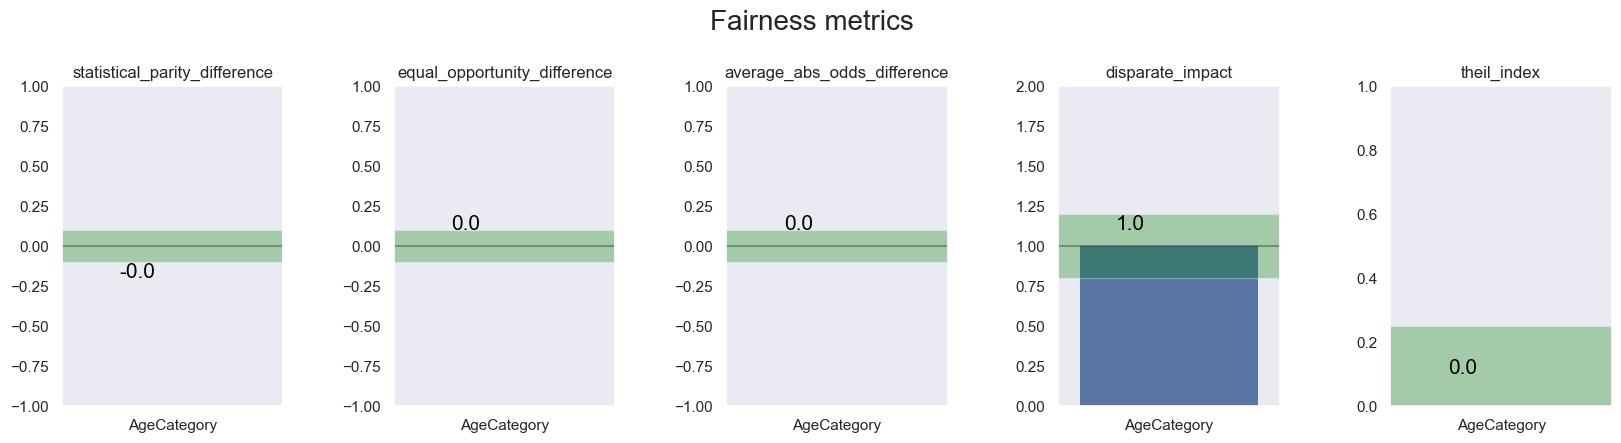

In [ ]:
display(Markdown('### Bias metrics for the Sex model'))
fair = get_fair_metrics_and_plot(dataset_transf_train, rf_orig_age)

Come possiamo vedere dal risultato raggiunto, le metriche riguardo la group fairness sono state risolte, mentre combare un bias relativo all'individual fairness. Questo risultato è tuttavia in accordo con la letteratura, nella quale è noto un trade off tra group e individual fairness.

# In processing technique

## Adversarial Debiasing

In [ ]:
from time import time

In [ ]:
def get_attributes(data, selected_attr=None):
    unprivileged_groups = []
    privileged_groups = []
    if selected_attr == None:
        selected_attr = data.protected_attribute_names

    for attr in selected_attr:
            idx = data.protected_attribute_names.index(attr)
            privileged_groups.append({attr:data.privileged_protected_attributes[idx]})
            unprivileged_groups.append({attr:data.unprivileged_protected_attributes[idx]})

    return privileged_groups, unprivileged_groups

In [ ]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_age_train, selected_attr=['AgeCategory'])
t0 = time()

In [ ]:
#sess.close()
#tf.reset_default_graph()
sess = tf.compat.v1.Session()

In [ ]:
tf.compat.v1.disable_eager_execution()

In [ ]:
debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier5',
                          num_epochs=100,
                          debias=True,
                          sess=sess)
debiased_model.fit(data_orig_age_train)

epoch 0; iter: 0; batch classifier loss: 4.560892; batch adversarial loss: 0.715077
epoch 1; iter: 0; batch classifier loss: 3.505752; batch adversarial loss: 0.753001
epoch 2; iter: 0; batch classifier loss: 3.552785; batch adversarial loss: 0.768824
epoch 3; iter: 0; batch classifier loss: 2.753235; batch adversarial loss: 0.718033
epoch 4; iter: 0; batch classifier loss: 2.680161; batch adversarial loss: 0.711815
epoch 5; iter: 0; batch classifier loss: 3.762526; batch adversarial loss: 0.762982
epoch 6; iter: 0; batch classifier loss: 3.307439; batch adversarial loss: 0.644069
epoch 7; iter: 0; batch classifier loss: 2.912429; batch adversarial loss: 0.694736
epoch 8; iter: 0; batch classifier loss: 2.740174; batch adversarial loss: 0.674544
epoch 9; iter: 0; batch classifier loss: 3.541023; batch adversarial loss: 0.728727
epoch 10; iter: 0; batch classifier loss: 2.217271; batch adversarial loss: 0.684745
epoch 11; iter: 0; batch classifier loss: 3.128512; batch adversarial loss:

In [ ]:
fair = get_fair_metrics_and_plot(data_orig_age_test, debiased_model, plot=False, model_aif=True)
data_pred = debiased_model.predict(data_orig_age_test)

algo_metrics = add_to_df_algo_metrics(algo_metrics, debiased_model, fair, data_pred.labels, data_pred.scores, 'AdvDebiasing')
print('time elapsed : %.2fs'%(time()-t0))

time elapsed : 1.60s


C:\Users\danie\AppData\Local\Temp\ipykernel_3416\2902889714.py:37: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\danie\AppData\Local\Temp\ipykernel_3416\2776106448.py:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [ ]:
metric_dataset_debiasing = BinaryLabelDatasetMetric(data_pred,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)


## Statistical Parity Difference

In [ ]:
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing.mean_difference())



Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.047407


## Disparate Impact

In [ ]:
print("Train set: Disparate Impact between unprivileged and privileged groups = %f" % metric_dataset_debiasing.disparate_impact())



Train set: Disparate Impact between unprivileged and privileged groups = 0.884668


## Equal Opportunity Difference

In [ ]:
classified_metric = ClassificationMetric(data_orig_age_test,
                                                     data_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

In [ ]:
print("Test set: Equal opportunity difference = %f" % classified_metric.equal_opportunity_difference())

Test set: Equal opportunity difference = 0.092352


## Average Absolute Odds Difference

In [ ]:
print("Test set: Average odds difference = %f" % classified_metric.average_odds_difference())

Test set: Average odds difference = 0.056631


## Theil Index

In [ ]:
print("Test set: Theil_index = %f" % classified_metric.theil_index())

Test set: Theil_index = 0.170710


# Prejudice Remover

In [ ]:
prej_model = PrejudiceRemover(sensitive_attr="AgeCategory",class_attr="Outcome")
prej_model.fit(data_orig_age_train)

In [ ]:
dataprej_pred = prej_model.predict(data_orig_age_test)

In [ ]:
metric_dataset_prej = BinaryLabelDatasetMetric(dataprej_pred,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

In [ ]:
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_prej.mean_difference())


Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.402398


In [ ]:
print("Train set: Disparate Impact between unprivileged and privileged groups = %f" % metric_dataset_prej.disparate_impact())



Train set: Disparate Impact between unprivileged and privileged groups = 0.101494


In [ ]:
classified_metric = ClassificationMetric(data_orig_age_test,
                                                     dataprej_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

In [ ]:
print("Test set: Equal opportunity difference = %f" % classified_metric.equal_opportunity_difference())

Test set: Equal opportunity difference = -0.516595


In [ ]:
print("Test set: Average odds difference = %f" % classified_metric.average_odds_difference())

Test set: Average odds difference = -0.394206


In [ ]:
print("Test set: Theil_index = %f" % classified_metric.theil_index())

Test set: Theil_index = 0.171343
